In [1]:
# 设置工作目录
path = '/home/yunneng/Hanting/'  

# 导入回测平台和需要用到的库
import pandas as pd
import numpy as np
import datetime
import pytz

from zipline.api import(
history,
add_history,
set_long_only,
get_datetime,
get_universe,
cancel_order,
order_target_percent,
order_target_value,
record,
get_open_orders,
)

import zipline as zp

select TRADEDATE from finchina2.TRDDATES                where TRADEDATE >= DATE('20020101') and TRADEDATE <= DATE('20161103')
trading dates successfully queried.


In [2]:
# 基于沪深300指数的MA（移动平均）策略

'''
================================================================================
总体回测前
================================================================================
'''
#总体回测前要做的事情
def initialize(context):
    context.target = target # 设置计算信号标的：沪深300指数
    context.security = security # 设置股票池
    # context.security = ["159919.XSHE","510300.XSHG"] # 设置股票池
    # 159919.XSHE：嘉实沪深300ETF；510300.XSHG：华泰柏瑞沪深300ETF
    # 设置短期和长期均线天数已经各自的天数间隔
    context.long_days = long_days 
    context.long_daydelta = long_daydelta
    context.short_days = short_days
    context.short_daydelta = short_daydelta 

'''
================================================================================
每天交易时
================================================================================
'''
def handle_data(context, data):
    # 设置每日股票池
    #cap = history(1, '1d', 'TOTMKTCAP')
    #cap = cap.iloc[-1,:]
    #cap.sort(inplace = True)
    #top10 = set(cap.index[-10:])
    #context.security = top10 # 设置股票池为每日市值最大的 10 支股票
    N = len(context.security) # 持仓数目
    
    portfolio = context.portfolio
    toSell = signal_stock_sell(context, data)
    toBuy = signal_stock_buy(context, data)

    # 卖出所有头寸以腾出资金
    if toSell == 1:
        for pos in [pos for pos in portfolio.positions.itervalues() if pos.amount >= 100]:
            order_target_value(pos.sid, 0)
    # 执行买入操作
    if toBuy == 1:
        for sid in context.security:
            if sid not in portfolio.positions:
                value = portfolio.cash / N       
                order_target_value(sid, value) 
    # if not toBuy or toSell:
        # locontext.info("今日无操作")
        # send_message("今日无操作")

#获得卖出信号
#输入：context, data
#输出：sell - list
def signal_stock_sell(context, data):
    sell = 0
    # 算出今天和昨天的两个移动均线的值
    (ma_long_pre,ma_long_now) = get_MA(context.long_days, context.long_daydelta)
    (ma_short_pre,ma_short_now) = get_MA(context.short_days, context.short_daydelta)
    # 如果短均线从上往下穿越长均线，则为死叉信号，标记卖出
    if ma_long_now < ma_long_pre and ma_short_now < ma_long_now and ma_short_pre > ma_long_pre:
    #if ma_short_now < ma_long_now and ma_short_pre > ma_long_pre:
    # and context.portfolio.positions[context.security[i]].sellable_amount > 0:
        sell = 1
    return sell

#获得买入信号
#输入：context, data
#输出：buy - list
def signal_stock_buy(context, data):
    buy = 0
    # 算出今天和昨天的两个移动均线的值，
    (ma_long_pre,ma_long_now) = get_MA(context.long_days, context.long_daydelta)
    (ma_short_pre,ma_short_now) = get_MA(context.short_days, context.short_daydelta)
    # 如果短均线从下往上穿越长均线，则为金叉信号，标记买入
    if ma_short_pre < ma_short_now and  ma_short_now > ma_long_now and ma_short_pre < ma_long_pre:
    #if ma_short_now > ma_long_now and ma_short_pre < ma_long_pre:
    # and context.portfolio.positions[context.security[i]].sellable_amount == 0 :
        buy = 1
    return buy

# 计算移动平均线数据
# 输入：股票代码-字符串，移动平均线天数-整数
# 输出：算术平均值-浮点数
def get_MA(days, daydelta):
    # 获得前days天的数据，详见API
    a = history(days+1, '1d', 'price')[target]
    # 定义一个局部变量sum，用于求和
    sum_now = 0
    sum_pre = 0
    # 对前days天每隔daydelta天的收盘价进行求和
    for i in range(1, days+1, daydelta):
        sum_now += a.iloc[-i]
    for i in range(2, days+2, daydelta):
        sum_pre += a.iloc[-i]
    # 求和之后除以天数就可以的得到算术平均值啦
    return (sum_pre/days*daydelta, sum_now/days*daydelta)

'''
================================================================================
每天收盘后
================================================================================
'''
# 每日收盘后要做的事情（本策略中不需要）
def after_trading_end(context):
    return

'''
================================================================================
设定回测参数
================================================================================
'''
# 设置策略参数
# 设置趋势标的及股票池
target = '2070000060'
security = ['2070000060'] # 设置股票池
# 短期和长期均线天数已经各自的天数间隔
long_days = 20 
long_daydelta = 1
short_days = 1
short_daydelta = 1 
#
period_start = '20140701'
period_end = '20151231'
TradingDictionary = {'initialize' : initialize,
                     'handle_data' : handle_data,
                     'period_start': period_start,
                     'period_end': period_end,
                     'benchmark': '2070000060',
                     'warming_period': 20,
                     'capital_base': 16000000.
                     } 
     
'''
================================================================================
生成一个回测器对象
================================================================================
'''   

algo = zp.TradingAlgorithm(**TradingDictionary)

'''
================================================================================
运行！结果返回到results中，并计算回测运行总时间
================================================================================
'''
%time results = algo.run(False)   


select TRADEDATE, TCLOSE from finchina2.TQ_QT_INDEX where SECODE = '2070000060'                and TRADEDATE >= DATE('20020101') and TRADEDATE <= DATE('20161103')
select TRADEDATE, M1, M3, M6, Y1, Y2, Y3, Y5, Y7, Y10, Y20, Y30 from finchina2.TREASURIES where                TRADEDATE >= DATE('20020101') and TRADEDATE <= DATE('20161103')
re-establish the connection
market data successfully queried.
select TCLOSE, THIGH, TLOW, TOPEN, PCHG, VOL, SECODE, TRADEDATE from finchina2.TQ_QT_SKDAILYPRICE where TCLOSE<>0 and TRADEDATE>=DATE('2014-06-11 00:00:00+00:00') and TRADEDATE<=DATE('20151231')         and EXCHANGE in ('001002', '001003')
select TCLOSE, THIGH, TLOW, TOPEN, PCHG, VOL, SECODE, TRADEDATE from finchina2.TQ_QT_INDEX where SECODE = '2070000060'                and TRADEDATE >= DATE('2014-06-11 00:00:00+00:00') and TRADEDATE <= DATE('20151231')


/home/yunneng/xiaoxu/zipline/zipline/dailydata/DBProxy.py:115: Warning: Truncated incorrect datetime value: '2014-06-11 00:00:00+00:00'
  cursor.execute(sql, params)


re-establish the connection
stock series successfully queried.
select DELISTDATE, SECODE from finchina2.TQ_SK_BASICINFO where EXCHANGE in ('001002', '001003')        and DELISTDATE > DATE('19900101') and DELISTDATE >= DATE('2014-06-11 00:00:00+00:00') and DELISTDATE <= DATE('20151231')
re-establish the connection
delist events successfully queried.
select A.PUBLISHDATE, A.PUBLISHDATE, A.SECODE, A.SECODE, A.SYMBOL, DIVITYPE, EQURECORDDATE, XDRDATE,         AFTTAXCASHDV, PROBONUSRT, TRANADDRT, BONUSRT, ISNEWEST from finchina2.TQ_SK_DIVIDENTS as A inner join         finchina2.TQ_SK_BASICINFO as B  where A.COMPCODE=B.COMPCODE AND B.EXCHANGE in ('001002', '001003') AND         A.EQURECORDDATE BETWEEN '2014-06-11 00:00:00+00:00' AND '20151231' AND A.ISNEWEST = 1
re-establish the connection
dividend data successfully queried.
select TCLOSE, THIGH, TLOW, TOPEN, PCHG, VOL, SECODE, TRADEDATE from finchina2.TQ_QT_SKDAILYPRICE where TCLOSE<>0 and TRADEDATE>=DATE('20140701') and TRADEDATE<=DATE('20

策略收益    策略年化收益     基准收益    基准年化收益    最大回撤
65.43%        40.51%          72.32%        44.44%        14.31% 


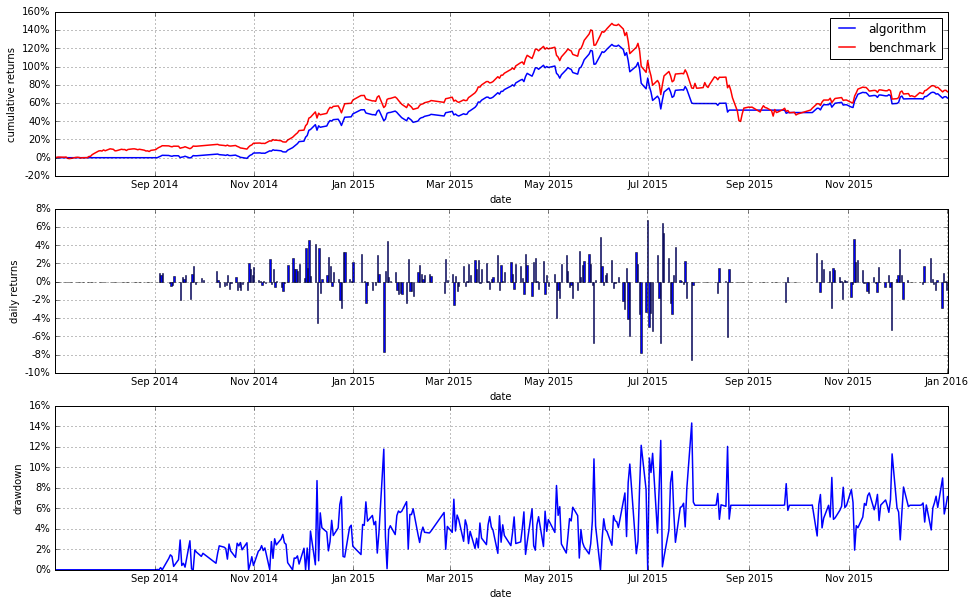

In [3]:
'''
回测结果可视化
'''
%matplotlib inline
from zipline.analysis import show_results as show

results_count = show.count(results, list(algo.perf_tracker.cumulative_risk_metrics.benchmark_returns))
show.plot_results(results_count)

In [4]:
'''
保存回测结果及下单记录
'''
import zipline.analysis.resolve_orders as resolve

algoname = 'MA-HS300-ETF'
results_name = path+'results_'+algoname+'_'+period_start+'_to_'+period_end+'.csv'
orderbook_name = path+'orderbook_'+algoname+'_'+period_start+'_to_'+period_end+'.xlsx'
# path为之前定义的自己的工作目录，alogname是自己定义的回测名称，period_start和period_end是之前定义过的回测起始日和结束日

results.to_csv(results_name) # 保存回测结果
resolve.resolve_orders(orderbook_name, results) # 保存下单记录

re-establish the connection


,amount,commission,sid,status,time,symbol
0,6700,4796.78460,2070000060,1,2014/09/01,000300
1,-6700,33194.62003,2070000060,1,2015/07/27,000300
2,6200,7564.00434,2070000060,1,2015/08/10,000300
3,-6200,31322.25616,2070000060,1,2015/08/18,000300
4,-7300,31174.64051,2070000060,1,2015/09/23,000300
5,7300,7310.85477,2070000060,1,2015/09/21,000300
6,-7200,34516.00152,2070000060,1,2015/12/04,000300
7,7200,7225.07529,2070000060,1,2015/10/08,000300
8,7000,7758.21690,2070000060,1,2015/12/14,000300
9,-7000,34178.58080,2070000060,1,2015/12/16,000300


In [5]:
# 基于沪深300指数的MA（移动平均）策略

'''
================================================================================
总体回测前
================================================================================
'''
#总体回测前要做的事情
def initialize(context):
    context.target = target # 设置计算信号标的：沪深300指数
    context.security = security # 设置股票池
    # context.security = ["159919.XSHE","510300.XSHG"] # 设置股票池
    # 159919.XSHE：嘉实沪深300ETF；510300.XSHG：华泰柏瑞沪深300ETF
    # 设置短期和长期均线天数已经各自的天数间隔
    context.long_days = long_days 
    context.long_daydelta = long_daydelta
    context.short_days = short_days
    context.short_daydelta = short_daydelta 

'''
================================================================================
每天交易时
================================================================================
'''
def handle_data(context, data):
    # 设置每日股票池
    #cap = history(1, '1d', 'TOTMKTCAP')
    #cap = cap.iloc[-1,:]
    #cap.sort(inplace = True)
    #top10 = set(cap.index[-10:])
    #context.security = top10 # 设置股票池为每日市值最大的 10 支股票
    N = len(context.security) # 持仓数目
    
    portfolio = context.portfolio
    toSell = signal_stock_sell(context, data)
    toBuy = signal_stock_buy(context, data)

    # 卖出所有头寸以腾出资金
    if toSell == 1:
        for pos in [pos for pos in portfolio.positions.itervalues() if pos.amount >= 100]:
            order_target_value(pos.sid, 0)
    # 执行买入操作
    if toBuy == 1:
        for sid in context.security:
            if sid not in portfolio.positions:
                value = portfolio.cash / N       
                order_target_value(sid, value) 
    # if not toBuy or toSell:
        # locontext.info("今日无操作")
        # send_message("今日无操作")

#获得卖出信号
#输入：context, data
#输出：sell - list
def signal_stock_sell(context, data):
    sell = 0
    # 算出今天和昨天的两个移动均线的值
    (ma_long_pre,ma_long_now) = get_MA(context.long_days, context.long_daydelta)
    (ma_short_pre,ma_short_now) = get_MA(context.short_days, context.short_daydelta)
    # 如果短均线从上往下穿越长均线，则为死叉信号，标记卖出
    if ma_long_now < ma_long_pre and ma_short_now < ma_long_now and ma_short_pre > ma_long_pre:
    #if ma_short_now < ma_long_now and ma_short_pre > ma_long_pre:
    # and context.portfolio.positions[context.security[i]].sellable_amount > 0:
        sell = 1
    return sell

#获得买入信号
#输入：context, data
#输出：buy - list
def signal_stock_buy(context, data):
    buy = 0
    # 算出今天和昨天的两个移动均线的值，
    (ma_long_pre,ma_long_now) = get_MA(context.long_days, context.long_daydelta)
    (ma_short_pre,ma_short_now) = get_MA(context.short_days, context.short_daydelta)
    # 如果短均线从下往上穿越长均线，则为金叉信号，标记买入
    if ma_short_pre < ma_short_now and  ma_short_now > ma_long_now and ma_short_pre < ma_long_pre:
    #if ma_short_now > ma_long_now and ma_short_pre < ma_long_pre:
    # and context.portfolio.positions[context.security[i]].sellable_amount == 0 :
        buy = 1
    return buy

# 计算移动平均线数据
# 输入：股票代码-字符串，移动平均线天数-整数
# 输出：算术平均值-浮点数
def get_MA(days, daydelta):
    # 获得前days天的数据，详见API
    a = history(days+1, '1d', 'price')[target]
    # 定义一个局部变量sum，用于求和
    sum_now = 0
    sum_pre = 0
    # 对前days天每隔daydelta天的收盘价进行求和
    for i in range(1, days+1, daydelta):
        sum_now += a.iloc[-i]
    for i in range(2, days+2, daydelta):
        sum_pre += a.iloc[-i]
    # 求和之后除以天数就可以的得到算术平均值啦
    return (sum_pre/days*daydelta, sum_now/days*daydelta)

'''
================================================================================
每天收盘后
================================================================================
'''
# 每日收盘后要做的事情（本策略中不需要）
def after_trading_end(context):
    return

'''
================================================================================
设定回测参数
================================================================================
'''
# 设置策略参数
# 设置趋势标的及股票池
target = '2070000060'
security = ['2070000060'] # 设置股票池
# 短期和长期均线天数已经各自的天数间隔
long_days = 20 
long_daydelta = 1
short_days = 1
short_daydelta = 1 
#
period_start = '20140101'
period_end = '20151231'
TradingDictionary = {'initialize' : initialize,
                     'handle_data' : handle_data,
                     'period_start': period_start,
                     'period_end': period_end,
                     'benchmark': '2070000060',
                     'warming_period': 20,
                     'capital_base': 16000000.
                     } 
     
'''
================================================================================
生成一个回测器对象
================================================================================
'''   

algo = zp.TradingAlgorithm(**TradingDictionary)

'''
================================================================================
运行！结果返回到results中，并计算回测运行总时间
================================================================================
'''
%time results = algo.run(False)   


select TRADEDATE, TCLOSE from finchina2.TQ_QT_INDEX where SECODE = '2070000060'                and TRADEDATE >= DATE('20020101') and TRADEDATE <= DATE('20161103')
select TRADEDATE, M1, M3, M6, Y1, Y2, Y3, Y5, Y7, Y10, Y20, Y30 from finchina2.TREASURIES where                TRADEDATE >= DATE('20020101') and TRADEDATE <= DATE('20161103')
re-establish the connection
re-establish the connection
market data successfully queried.
select TCLOSE, THIGH, TLOW, TOPEN, PCHG, VOL, SECODE, TRADEDATE from finchina2.TQ_QT_SKDAILYPRICE where TCLOSE<>0 and TRADEDATE>=DATE('2013-12-13 00:00:00+00:00') and TRADEDATE<=DATE('20151231')         and EXCHANGE in ('001002', '001003')
select TCLOSE, THIGH, TLOW, TOPEN, PCHG, VOL, SECODE, TRADEDATE from finchina2.TQ_QT_INDEX where SECODE = '2070000060'                and TRADEDATE >= DATE('2013-12-13 00:00:00+00:00') and TRADEDATE <= DATE('20151231')
re-establish the connection


/home/yunneng/xiaoxu/zipline/zipline/dailydata/DBProxy.py:115: Warning: Truncated incorrect datetime value: '2013-12-13 00:00:00+00:00'
  cursor.execute(sql, params)


re-establish the connection
stock series successfully queried.
select DELISTDATE, SECODE from finchina2.TQ_SK_BASICINFO where EXCHANGE in ('001002', '001003')        and DELISTDATE > DATE('19900101') and DELISTDATE >= DATE('2013-12-13 00:00:00+00:00') and DELISTDATE <= DATE('20151231')
re-establish the connection
delist events successfully queried.
select A.PUBLISHDATE, A.PUBLISHDATE, A.SECODE, A.SECODE, A.SYMBOL, DIVITYPE, EQURECORDDATE, XDRDATE,         AFTTAXCASHDV, PROBONUSRT, TRANADDRT, BONUSRT, ISNEWEST from finchina2.TQ_SK_DIVIDENTS as A inner join         finchina2.TQ_SK_BASICINFO as B  where A.COMPCODE=B.COMPCODE AND B.EXCHANGE in ('001002', '001003') AND         A.EQURECORDDATE BETWEEN '2013-12-13 00:00:00+00:00' AND '20151231' AND A.ISNEWEST = 1
re-establish the connection
dividend data successfully queried.
select TCLOSE, THIGH, TLOW, TOPEN, PCHG, VOL, SECODE, TRADEDATE from finchina2.TQ_QT_SKDAILYPRICE where TCLOSE<>0 and TRADEDATE>=DATE('20140102') and TRADEDATE<=DATE('20

策略收益    策略年化收益     基准收益    基准年化收益    最大回撤
65.77%        29.48%          60.13%        27.21%        14.28% 


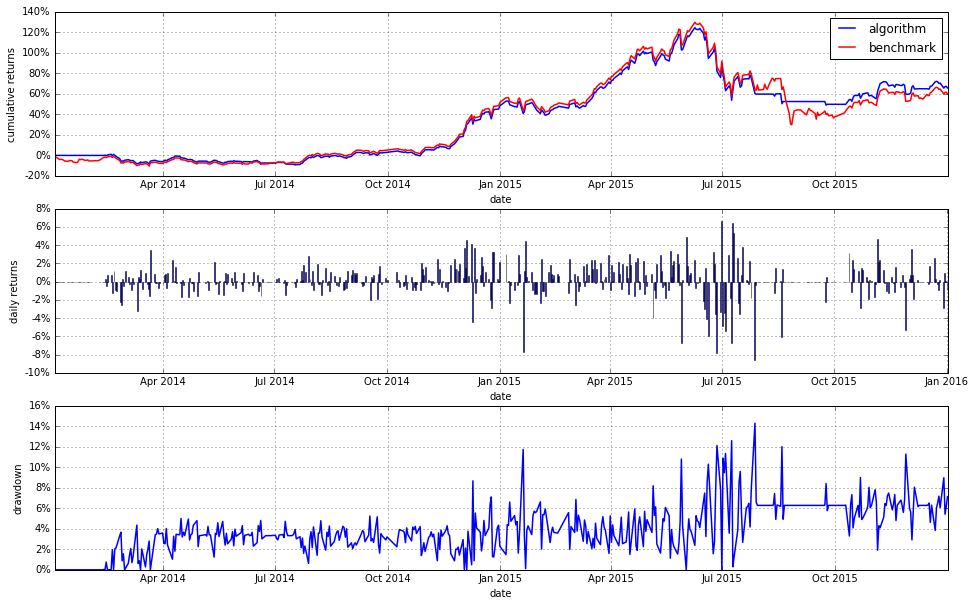

In [6]:
'''
回测结果可视化
'''
%matplotlib inline
from zipline.analysis import show_results as show

results_count = show.count(results, list(algo.perf_tracker.cumulative_risk_metrics.benchmark_returns))
show.plot_results(results_count)

In [7]:
'''
保存回测结果及下单记录
'''
import zipline.analysis.resolve_orders as resolve

algoname = 'MA-HS300-ETF'
results_name = path+'results_'+algoname+'_'+period_start+'_to_'+period_end+'.csv'
orderbook_name = path+'orderbook_'+algoname+'_'+period_start+'_to_'+period_end+'.xlsx'
# path为之前定义的自己的工作目录，alogname是自己定义的回测名称，period_start和period_end是之前定义过的回测起始日和结束日

results.to_csv(results_name) # 保存回测结果
resolve.resolve_orders(orderbook_name, results) # 保存下单记录

re-establish the connection
re-establish the connection


,amount,commission,sid,status,time,symbol
0,7000,4799.68020,2070000060,1,2014/02/10,000300
1,-7000,19570.47820,2070000060,1,2014/06/04,000300
2,6900,4418.86212,2070000060,1,2014/06/05,000300
3,-6900,19144.50057,2070000060,1,2014/06/06,000300
4,6900,4472.78562,2070000060,1,2014/06/10,000300
5,-6900,19166.45913,2070000060,1,2014/06/19,000300
6,6800,4416.84072,2070000060,1,2014/06/27,000300
7,-6800,18942.76748,2070000060,1,2014/07/09,000300
8,6700,4371.70176,2070000060,1,2014/07/14,000300
9,-6700,33194.62003,2070000060,1,2015/07/27,000300
